In [1]:
import sys
from pathlib import Path

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import os
os.chdir(project_root)

In [2]:
import torch
from torch.utils.data import DataLoader

from src.data.pipeline import get_datasets
from src.models.transformer_model import StockTransformer
from src.training.trainer import Trainer
from src.utils.config import load_config

config = load_config()

train_dataset, val_dataset, test_dataset, feature_columns = get_datasets(config)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.training.batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.training.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

model = StockTransformer(
    input_dim=len(feature_columns),
    d_model=config.model.d_model,
    n_heads=config.model.n_heads,
    n_layers=config.model.n_layers,
    d_ff=config.model.d_ff,
    dropout=config.model.dropout,
    activation=config.model.activation,
    prediction_horizon=config.data.prediction_horizon,
)

trainer = Trainer(
    model=model,
    config=config,
    train_loader=train_loader,
    val_loader=val_loader,
)

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (10068, 25)


In [3]:
history = trainer.train()

print(f"\n{'='*60}")
print(f"Обучението завърши!")
print(f"Best validation loss: {history['best_val_loss']:.6f}")
print(f"{'='*60}")

# Use project root for absolute path (same as in 05_backtest_simulation)
from src.utils import config as _cfg
checkpoint_name = getattr(config.paths, "checkpoint_file", "best_model.pt")
checkpoint_path = _cfg.PROJECT_ROOT / config.paths.models_dir / checkpoint_name

# Ensure directory exists
checkpoint_path.parent.mkdir(parents=True, exist_ok=True)

print(f"\nЗапазване на модела в: {checkpoint_path}")
torch.save({
    'epoch': len(history['train_losses']) - 1,
    'model_state_dict': model.state_dict(),
    'score': history['best_val_loss'],
}, checkpoint_path)

# VERIFICATION: Check that file exists and can be loaded
if checkpoint_path.exists():
    import time
    file_size = checkpoint_path.stat().st_size / (1024 * 1024)  # MB
    mtime = time.ctime(checkpoint_path.stat().st_mtime)
    print(f"✓ Файлът е запазен успешно!")
    print(f"  Размер: {file_size:.2f} MB")
    print(f"  Модифициран: {mtime}")
    
    # Try loading it back to verify
    try:
        test_checkpoint = torch.load(checkpoint_path, map_location="cpu")
        if "model_state_dict" in test_checkpoint and "score" in test_checkpoint:
            print(f"✓ Проверка: Файлът може да се зареди обратно")
            print(f"  Epoch: {test_checkpoint.get('epoch', '?') + 1}")
            print(f"  Val loss: {test_checkpoint.get('score', '?'):.6f}")
            print(f"  Параметри: {len(test_checkpoint['model_state_dict'])} keys")
        else:
            print(f"⚠ ВНИМАНИЕ: Файлът липсва ключови полета!")
    except Exception as e:
        print(f"✗ ГРЕШКА при зареждане на файла: {e}")
else:
    print(f"✗ ГРЕШКА: Файлът не беше създаден!")

Започване на обучение за 50 epochs...

Epoch 1/50... Train loss: 0.064972 Val loss: 0.059849 (17.8s)

Epoch 2/50... Train loss: 0.020823 Val loss: 0.038312 (17.8s)

Epoch 3/50... Train loss: 0.016653 Val loss: 0.025582 (25.7s)

Epoch 4/50... Train loss: 0.014475 Val loss: 0.042212 (25.1s)

Epoch 5/50... Train loss: 0.014064 Val loss: 0.041476 (25.1s)

Epoch 6/50... Train loss: 0.013945 Val loss: 0.032246 (25.3s)

Epoch 7/50... Train loss: 0.013716 Val loss: 0.020763 (18.0s)

Epoch 8/50... Train loss: 0.013696 Val loss: 0.032882 (19.1s)

Epoch 9/50... Train loss: 0.012901 Val loss: 0.024869 (24.9s)

Epoch 10/50... Train loss: 0.012547 Val loss: 0.024221 (24.7s)

Epoch 11/50... Train loss: 0.012681 Val loss: 0.019538 (23.2s)

Epoch 12/50... Train loss: 0.012837 Val loss: 0.019312 (18.1s)

Epoch 13/50... Train loss: 0.012171 Val loss: 0.017946 (23.3s)

Epoch 14/50... Train loss: 0.012183 Val loss: 0.019360 (23.7s)

Epoch 15/50... Train loss: 0.011853 Val loss: 0.018126 (22.3s)

Epoch 16/5

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from src.evaluation.metrics import calculate_metrics

test_loader = DataLoader(
    test_dataset,
    batch_size=config.training.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

print("Тестване на модела...")
model.eval()

all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        predictions = model(batch_x)
        
        if predictions.dim() == 1:
            predictions = predictions.unsqueeze(1)
        if batch_y.dim() == 1:
            batch_y = batch_y.unsqueeze(1)
        
        all_predictions.append(predictions)
        all_targets.append(batch_y)

predictions = torch.cat(all_predictions, dim=0)
targets = torch.cat(all_targets, dim=0)

metrics = calculate_metrics(predictions, targets)

print("\n" + "="*60)
print("РЕЗУЛТАТИ НА TEST SET:")
print("="*60)
for metric_name, value in metrics.items():
    if metric_name == "mape":
        print(f"{metric_name.upper()}: {value:.2f}%")
    elif metric_name == "directional_accuracy":
        print(f"{metric_name.upper()}: {value*100:.2f}%")
    else:
        print(f"{metric_name.upper()}: {value:.6f}")
print("="*60)

Тестване на модела...

РЕЗУЛТАТИ НА TEST SET:
MAE: 0.057964
RMSE: 0.072650
MAPE: 8.04%
R2: 0.362450
DIRECTIONAL_ACCURACY: 50.07%


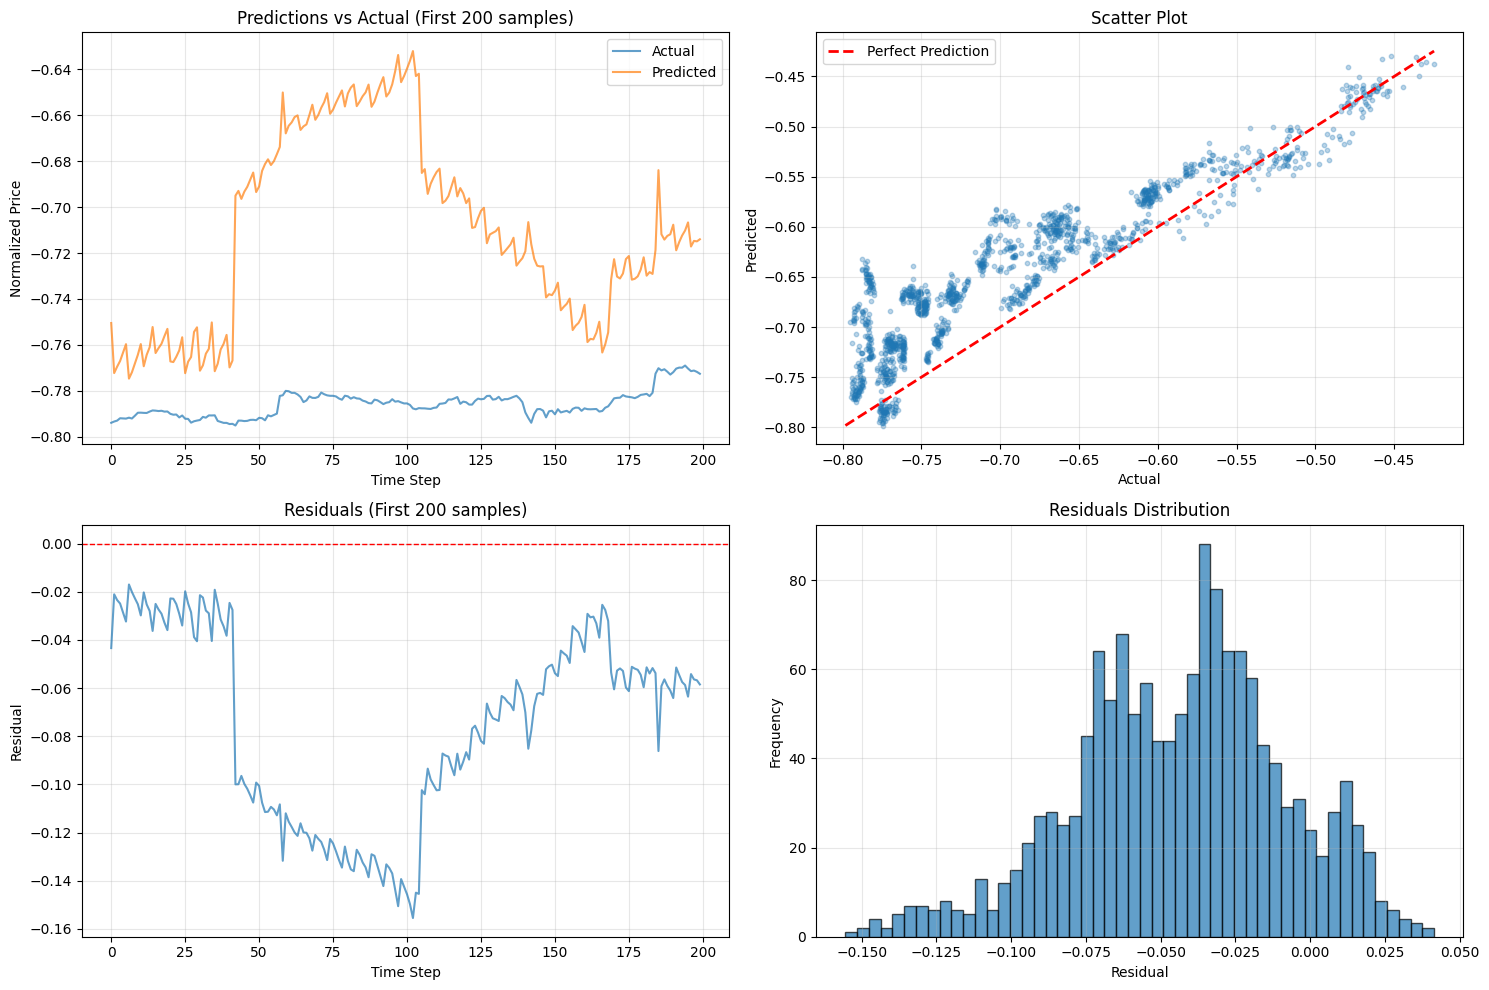


Статистики на residuals:
  Mean: -0.043911
  Std: 0.035357
  Min: -0.155470
  Max: 0.041457


In [6]:
predictions_np = predictions.numpy().flatten()
targets_np = targets.numpy().flatten()

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(targets_np[:200], label="Actual", alpha=0.7, linewidth=1.5)
plt.plot(predictions_np[:200], label="Predicted", alpha=0.7, linewidth=1.5)
plt.xlabel("Time Step")
plt.ylabel("Normalized Price")
plt.title("Predictions vs Actual (First 200 samples)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.scatter(targets_np, predictions_np, alpha=0.3, s=10)
min_val = min(np.min(targets_np), np.min(predictions_np))
max_val = max(np.max(targets_np), np.max(predictions_np))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label="Perfect Prediction")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Scatter Plot")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
residuals = targets_np - predictions_np
plt.plot(residuals[:200], alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel("Time Step")
plt.ylabel("Residual")
plt.title("Residuals (First 200 samples)")
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nСтатистики на residuals:")
print(f"  Mean: {np.mean(residuals):.6f}")
print(f"  Std: {np.std(residuals):.6f}")
print(f"  Min: {np.min(residuals):.6f}")
print(f"  Max: {np.max(residuals):.6f}")